# Figure 5

### Load functions and packages

In [1]:
import os

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import copy

import regionmask
import cartopy.crs as ccrs

from matplotlib.colors import BoundaryNorm

%matplotlib inline

In [2]:
def sp_map(*nrs, projection = ccrs.PlateCarree(), **kwargs):
    return plt.subplots(*nrs, subplot_kw={'projection':projection}, **kwargs)


def to_png(file, filename, loc='/glade/u/home/jonahshaw/figures/',dpi=200,ext='png',**kwargs):
    '''
    Simple function for one-line saving.
    Saves to "/glade/u/home/jonahshaw/figures" by default
    '''
    output_dir = loc
    full_path = '%s%s.%s' % (output_dir,filename,ext)

    if not os.path.exists(output_dir + filename):
        file.savefig(full_path,format=ext, dpi=dpi,**kwargs)
        
    else:
        print('File already exists, rename or delete.')

In [3]:
def convert_ipcc_to_latlon(
    data: xr.DataArray,
    mask: regionmask.Regions = regionmask.defined_regions.ar6.all,
):

    mean_data   = data.sel(metric='mean')
    strict_data = data.sel(metric='strict')
    delay_data  = data.sel(metric='delay')
    delay_mask  = data.sel(metric='delay_mask')

    unc_mask = mask.mask(np.arange(-179.5, 180, 0.5),np.arange(-89.5, 90, 0.5),)

    _mean_mask   = unc_mask.copy()
    _strict_mask = unc_mask.copy()
    _delay_data_mask  = unc_mask.copy()
    _delay_mask_mask  = unc_mask.copy()

    del unc_mask

    offset = -1000 # Need an offset or it may confuse regions with the delays (delays are on [0,40] similar to the region indices)
    for i in mask.numbers:
        
        _mean_mask   = xr.where(_mean_mask==i,mean_data.sel(RegionIndex=i)+offset,_mean_mask)
        _strict_mask = xr.where(_strict_mask==i,strict_data.sel(RegionIndex=i)+offset,_strict_mask)
        _delay_data_mask  = xr.where(_delay_data_mask==i,delay_data.sel(RegionIndex=i)+offset,_delay_data_mask)
        _delay_mask_mask  = xr.where(_delay_mask_mask==i,delay_mask.sel(RegionIndex=i)+offset,_delay_mask_mask)

    regional_masked_da = xr.concat([_mean_mask,_strict_mask,_delay_data_mask,_delay_mask_mask],dim='metric')-offset
    
    return regional_masked_da

## Load computed ToE data

In [4]:
toe_savedir = "../data/20250617/"

spatial_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.5x5.nc").drop_sel(obs=["DCENT_unfilled", "BEST", "BEST_any"])
regional_masked_da = xr.open_dataarray(f"{toe_savedir}/ToE_delay.IPCCRegions.nc").drop_sel(obs=["DCENT_unfilled", "BEST", "BEST_any"])

Need to convert the IPCC Region Indexing to lat-lon coordinates in order to plot spatially.

In [5]:
# Apply the land mask here.
mask = regionmask.defined_regions.ar6.land
regional_latlon_da = convert_ipcc_to_latlon(
    regional_masked_da,
    mask=mask,
)
landmask = ~np.isnan(mask.mask(regional_latlon_da["lon"], regional_latlon_da["lat"],))

In [6]:
# Make a better land mask for the spatial 5x5 deg. regions
land = regionmask.defined_regions.natural_earth_v5_0_0.land_110.mask_3D_frac_approx(
    spatial_masked_da
).squeeze()
spatial_landmask = land>0.5

In [7]:
spatial_landmasked_da = spatial_masked_da.where(landmask).squeeze()

#### Plot the spread over models vs. over the observational products.

Compute the spread values:

- The obs. spread is the average separation between 1 model with both obs. products
- The model spread is the spread for all models with one observational product, averaged for the two obs. products

In [8]:
spatial_toe_mean = spatial_masked_da.sel(metric='mean')
spatial_toe_strict = spatial_masked_da.sel(metric='strict')

spatial_mean_obs_spread = (spatial_toe_mean.max(dim='obs') - spatial_toe_mean.min(dim='obs')).mean(dim='model') # Average spread between GISTEMP and HadCRUT
spatial_mean_mod_spread = (spatial_toe_mean.max(dim='model') - spatial_toe_mean.min(dim='model')).mean(dim='obs')

spatial_strict_obs_spread = (spatial_toe_strict.max(dim='obs') - spatial_toe_strict.min(dim='obs')).mean(dim='model')
spatial_strict_mod_spread = (spatial_toe_strict.max(dim='model') - spatial_toe_strict.min(dim='model')).mean(dim='obs')

spatial_mean_spread = spatial_toe_mean.max(dim=["model", "obs"]) - spatial_toe_mean.min(dim=["model", "obs"])
spatial_mean_spread = spatial_mean_spread.where(~np.isnan(spatial_mean_obs_spread) & ~np.isnan(spatial_mean_mod_spread))
spatial_strict_spread = spatial_toe_strict.max(dim=["model", "obs"]) - spatial_toe_strict.min(dim=["model", "obs"])
spatial_strict_spread = spatial_strict_spread.where(~np.isnan(spatial_strict_obs_spread) & ~np.isnan(spatial_strict_mod_spread))

In [9]:
# spatial_toe_mean = spatial_masked_da.sel(metric='mean')
# spatial_toe_strict = spatial_masked_da.sel(metric='strict')

# spatial_mean_obs_spread = (spatial_toe_mean.max(dim='obs') - spatial_toe_mean.min(dim='obs')).mean(dim='model') # Average spread between GISTEMP and HadCRUT
# spatial_mean_mod_spread = (spatial_toe_mean.max(dim='model') - spatial_toe_mean.min(dim='model')).mean(dim='obs')

# spatial_strict_obs_spread = (spatial_toe_strict.max(dim='obs') - spatial_toe_strict.min(dim='obs')).mean(dim='model')
# spatial_strict_mod_spread = (spatial_toe_strict.max(dim='model') - spatial_toe_strict.min(dim='model')).mean(dim='obs')

# spatial_mean_spread = spatial_toe_mean.max(dim=["model", "obs"]) - spatial_toe_mean.min(dim=["model", "obs"])
# spatial_mean_spread = spatial_mean_spread.where(~np.isnan(spatial_mean_obs_spread) & ~np.isnan(spatial_mean_mod_spread))
# spatial_strict_spread = spatial_toe_strict.max(dim=["model", "obs"]) - spatial_toe_strict.min(dim=["model", "obs"])
# spatial_strict_spread = spatial_strict_spread.where(~np.isnan(spatial_strict_obs_spread) & ~np.isnan(spatial_strict_mod_spread))

#### Spatial Data

In [10]:
def plot_spatial_spread3(
    total_spread,
    obs_spread,
    model_spread,
    title=True,
    surfacemask=None,
    surfacehatch="o",
    countmask=None,
    counthatch="xx",
    spread_levels=np.linspace(0, 30, 7),
):
    fig,axs = sp_map(1,3,projection=ccrs.Robinson(),figsize=(21,6))
    axs = axs.flat

    cax1 = plt.axes([0.275, 0.22, 0.50, 0.03])

    ToE_cmap = copy.copy(mpl.cm.viridis)
    # ToE_cmap = copy.copy(mpl.cm.autumn_r)
    # ToE_cmap = copy.copy(mpl.cm.YlOrBr) # 
        
    # spread_levels = np.linspace(0,30,7)

    masks  = [total_spread, obs_spread, model_spread]
    titles = ["Total Spread", 'Observation Spread','Model Spread']
    levels = [spread_levels, spread_levels, spread_levels] 
    cmaps = [ToE_cmap, ToE_cmap, ToE_cmap]
    extend = ['max','max','max']

    plt.subplots_adjust(wspace=0.05)
    
    ims = [] 
    for _ax,_mask,_label,_levels,_cmap,_extend in zip(axs,masks,titles,levels,cmaps,extend):
        _norm = BoundaryNorm(_levels, ncolors=_cmap.N, clip=False,extend=_extend)
        im = _ax.pcolormesh(_mask.lon,_mask.lat,_mask,
                           transform=ccrs.PlateCarree(),
                           cmap=_cmap,
                           norm=_norm, 
                           )

        _ = _ax.contourf(_mask.lon,_mask.lat,np.isnan(_mask),
                         transform=ccrs.PlateCarree(),
                         levels=[0,0.5,1.5],
                         extend='max',
                         colors=['none','gray'],
                        #  hatches=[None,'..',],
                        )     

        _ax.coastlines()
        _ax.set_global()
        _ax.set_title(_label,fontsize=16)

        ims.append(im)
        if countmask is not None:
            _ = _ax.contourf(
                countmask.lon,
                countmask.lat,
                (~countmask & surfacemask),
                levels=[0,0.5,2],
                transform=ccrs.PlateCarree(),
                colors=["none", "none"],
                hatches=[None, counthatch,],
                extend='max',
           )
    # for _ax in axs:
        if surfacemask is not None:
            _ = _ax.contourf(
                surfacemask.lon,
                surfacemask.lat,
                ~surfacemask,
                levels=[0,0.5,2],
                colors='none',
                transform=ccrs.PlateCarree(),
                hatches=[None, surfacehatch,],
                extend='max',
           )

    cbar1 = fig.colorbar(ims[0],orientation='horizontal',
                         ticks=spread_levels,
                         cax=cax1,#label='Years',
                         extend='max',
                        )
    cbar1.set_label(label='Years',size=15,weight=None)
    cbar1.ax.tick_params(labelsize=12) 

    fig.text(0.14, 0.68, "a.", fontsize=14)
    fig.text(0.40, 0.68, "b.", fontsize=14)
    fig.text(0.665, 0.68, "c.", fontsize=14)

    if title:
        fig.suptitle('Method Spread',fontsize=20,y=0.88)    

    return fig

The white splotches are gridcells where the ratio actually becomes pretty even. I could do some more smoothing, but I'm not sure that's the right approach.

__Observational Uncertainty Dominates in the Tropics, Model Uncertainty dominates in the northern hemisphere. The Southern Ocean hasn't emerged so we don't assess spread there.__

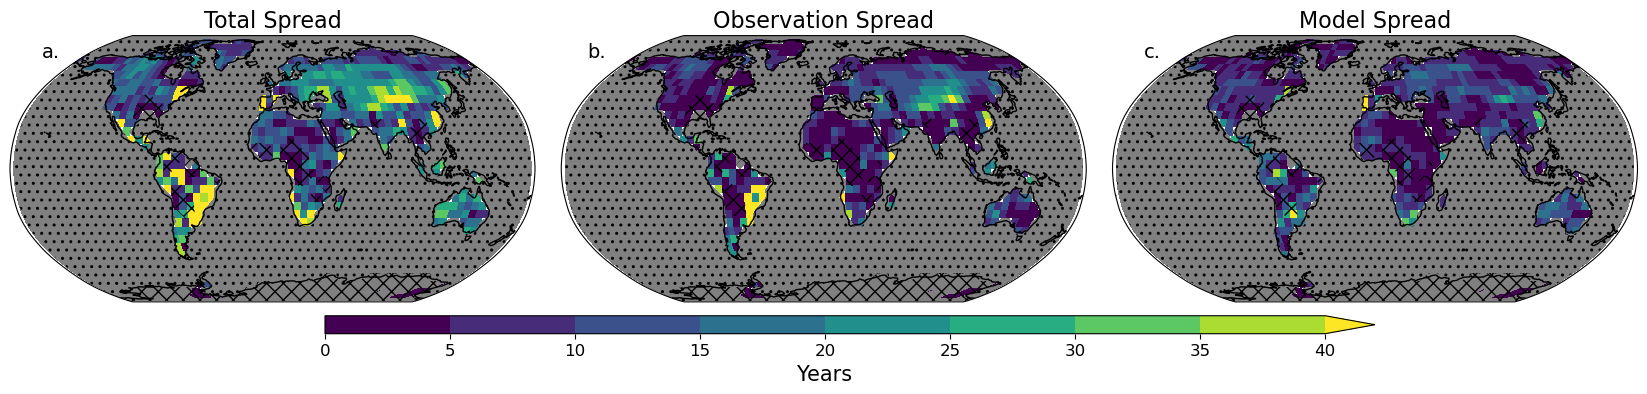

In [11]:
spatial_strict_obs_spread_land = spatial_strict_obs_spread.where(spatial_landmask).squeeze()
spatial_strict_mod_spread_land = spatial_strict_mod_spread.where(spatial_landmask).squeeze()
spatial_strict_spread_land = spatial_strict_spread.where(spatial_landmask).squeeze()

count_mask = (spatial_toe_strict.count(dim=["model", "obs"]) > 4).squeeze()

out_fig = plot_spatial_spread3(
    spatial_strict_spread_land,
    spatial_strict_obs_spread_land,
    spatial_strict_mod_spread_land,
    surfacemask=spatial_landmask,
    surfacehatch="..",
    countmask=count_mask,
    spread_levels=np.linspace(0, 40, 9),
    title=False,
)


In [12]:
to_png(
    file=out_fig,
    filename='StrictToE_spread_spatialmap_land',
    loc='../figures/',
    dpi=300,
    ext='pdf',
    bbox_inches='tight',
)